In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS

---

### Notes
(Les idées viennent d'une tuto Youtube)

<ins>Objectif</ins> :
- Comprendre du mieux possible nos données (un petit pas en avant vaut mieux qu'un grand pas en arriere)
- Développer une premiere stratégie de modélisation

<ins>Notes Random Général</ins> :
- ```sns.pairplot``` : les couleurs dans ```hue``` pour les clusters, c'est mieux qu'elles soient contrastées
- Après avoir créé les 10 clusters, on observe les stats pour chaque clusters dans la partie de l'histogramme (diagonale)

<ins>Tâches</ins> :
- Définir les potentiels objectifs

---

### Checklist de base

#### Objectifs :
- Qu'est-ce qu'on essaie de prouver avec ?

#### Analyse de Forme :
- **variable target** : 
- **lignes et colonnes** : 
- **types de variables** :
    - qualitatifs : 
    - quantitatifs : 
- **Analyse des valeurs manquantes** :
- **Notes random** :

#### Analyse de Fond :
- **Visualisation de la target** :
- **Signification des variables** :
- **Relation Variables / Target** :

#### Analyse plus détaillée :
- **Relation Variables / Variables** :
- **NaN analyse** :

#### hypotheses nulle (H0) :
- Permet de voir si des analyses contiennent des changements significatifs

In [3]:
# Chargement des données
file_path = 'data/immodataParis.csv'
data = pd.read_csv(file_path)

### Analyse de Forme :
- **variable target** : 
- **lignes et colonnes** : 1654 lignes et dans notre méthode de scrapping, on ne prend pas en compte les valeurs manquantes
- **Notes random** :
    - On a beaucoup de outliers qui empêchent de bien visualiser les graphes (On le voit bien avec sns.pairplot). Solution : ?
    - Par exemple, je pense pas qu'on va garder les appartements à plus de 200 m² (en vrai pourquoi pas, mais y a trop peu de données dessus)
    - Ou alors avec quelques lignes de code et sklearn, détecter automatiquement les outliers et faire du pré-processing après ça.

#### Visualisation

In [52]:
df = data.copy()
df.shape
df.dtypes.value_counts() # Différentes types de données des colonnes

int64     5
object    4
Name: count, dtype: int64

In [5]:
df.head()

,Adresse,Ville,Arrondissement,Type,Prix (€),Prix mensuel (€),Pièce(s),Surface (m2),Date de vente
0,270 RUE SAINT-HONORÉ,PARIS,75001,Appartement,750400,14431,2,52,22/05/2023
1,186 RUE DE RIVOLI,PARIS,75001,Appartement,330000,14348,1,23,28/04/2023
2,23 RUE DE RICHELIEU,PARIS,75001,Appartement,360100,15657,1,23,29/03/2023
3,27 RUE DE RICHELIEU,PARIS,75001,Appartement,286123,11005,1,26,10/02/2023
4,272 RUE SAINT-HONORÉ,PARIS,75001,Appartement,411636,12864,2,32,28/12/2022


In [6]:
df.columns

Index(['Adresse', 'Ville', 'Arrondissement', 'Type', 'Prix (€)',
       'Prix mensuel (€)', 'Pièce(s)', 'Surface (m2)', 'Date de vente'],
      dtype='object')

- **Adresse** : Inutile pour l'analyse
- **Ville** : Uniquement à Paris
- **Type** : Uniquement des appartements

In [39]:
df = df[['Arrondissement', 'Prix (€)',
       'Prix mensuel (€)', 'Pièce(s)', 'Surface (m2)', 'Date de vente']].copy()

# Retirer les colonnes Adresse, Ville et Type pour les raisons énoncées juste en haut
df.head()

,Arrondissement,Prix (€),Prix mensuel (€),Pièce(s),Surface (m2),Date de vente
0,75001,750400,14431,2,52,22/05/2023
1,75001,330000,14348,1,23,28/04/2023
2,75001,360100,15657,1,23,29/03/2023
3,75001,286123,11005,1,26,10/02/2023
4,75001,411636,12864,2,32,28/12/2022


#### Statistiques et Filtres

In [7]:
# Counting
nb_Value = df['Ville'].value_counts()

nb_Value

Ville
PARIS    1654
Name: count, dtype: int64

In [8]:
# Sorting
df.sort_values('Surface (m2)')

,Adresse,Ville,Arrondissement,Type,Prix (€),Prix mensuel (€),Pièce(s),Surface (m2),Date de vente
762,142 RUE DU FAUBOURG SAINT-DENIS,PARIS,75010,Appartement,20000,6667,1,3,27/01/2022
687,46 RUE LAMARTINE,PARIS,75009,Appartement,19000,3800,1,5,01/04/2021
664,17 RUE DE CHÂTEAUDUN,PARIS,75009,Appartement,40000,8000,1,5,27/10/2021
552,2 RUE MALEVILLE,PARIS,75008,Appartement,60000,10000,1,6,23/05/2023
206,3 RUE PAUL DUBOIS,PARIS,75003,Appartement,105000,17500,1,6,06/11/2018
...,...,...,...,...,...,...,...,...,...
1232,77 AVENUE HENRI MARTIN,PARIS,75016,Appartement,2090000,6147,7,340,14/01/2023
1210,77 AVENUE HENRI MARTIN,PARIS,75016,Appartement,5271700,15505,7,340,26/06/2023
1283,87 AVENUE HENRI MARTIN,PARIS,75016,Appartement,5228950,13072,9,400,17/11/2021
362,151B RUE SAINT-JACQUES,PARIS,75005,Maison,19346000,43377,13,446,15/03/2021


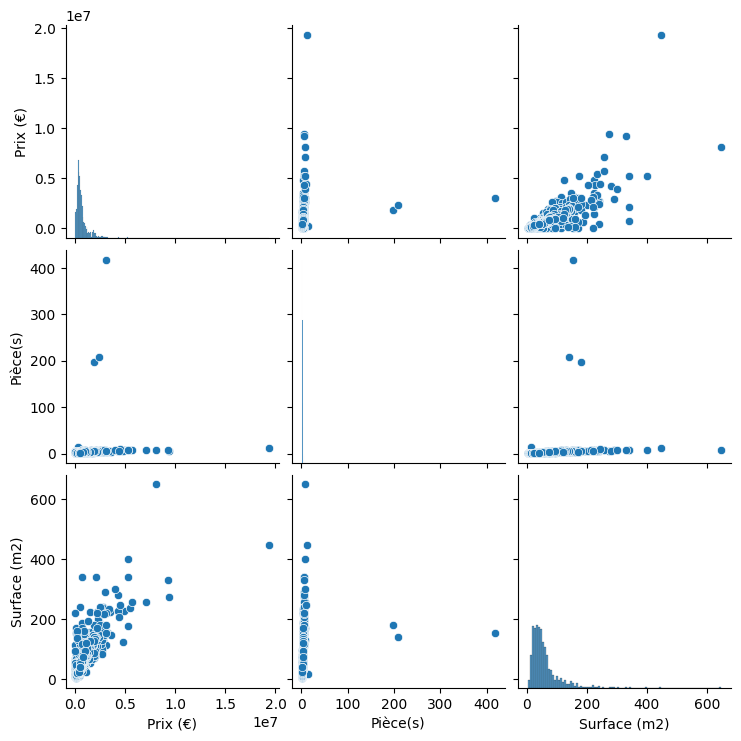

In [9]:
# Pour une meilleure visualisation, peut-être mettre de la couleur
# en fonction des labels correspondant à des clusters différents

sns.pairplot(df[['Prix (€)', 'Pièce(s)', 'Surface (m2)']])

In [10]:
# Clustering 
# Transformation Données > Normalisation > Clustering 
# (ce serait mieux que de directement faire du Clustering, le faire
# dans la partie Modelling)
# Dans la partie 'Modelling', il faudra ajuster le nombre de clusters
# Peut-être en utilisant GridSearchCV

from sklearn.cluster import AgglomerativeClustering

new_df = df[["Prix (€)","Pièce(s)","Surface (m2)"]]
clustering = AgglomerativeClustering(n_clusters=10, linkage='ward')
cluster_labels = clustering.fit_predict(new_df)
new_df['Cluster'] = cluster_labels # C'est pour voir les différents cluster avec sns

/var/folders/jl/05xr553n44v3_nqnn57t0f380000gn/T/ipykernel_16712/248202620.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['Cluster'] = cluster_labels # C'est pour voir les différents cluster avec sns


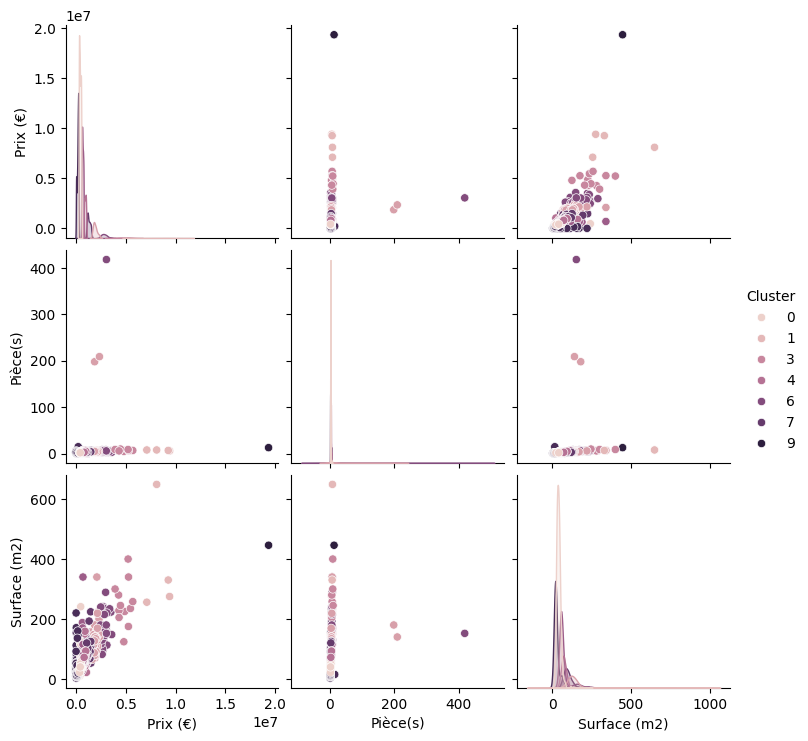

In [11]:
sns.pairplot(new_df, hue='Cluster')

### Analyse de Fond :
- **Visualisation de la target** :
- **Signification des variables** :
- **Relation Variables / Target** :

In [12]:
numerical_df = df.select_dtypes(include=['int64', 'float64'])
numerical_df.describe(include='all')

,Arrondissement,Prix (€),Prix mensuel (€),Pièce(s),Surface (m2)
count,1654.000000,1.654000e+03,1654.000000,1654.000000,1654.000000
mean,75010.814994,7.042688e+05,11563.597944,3.041112,57.406288
std,5.770641,9.048061e+05,4469.083216,12.453208,47.797117
min,75001.000000,0.000000e+00,0.000000,1.000000,3.000000
25%,75006.000000,2.900000e+05,9615.500000,2.000000,28.000000
50%,75011.000000,4.716035e+05,11272.000000,2.000000,45.000000
75%,75016.000000,7.700000e+05,13474.000000,3.000000,68.000000
max,75020.000000,1.934600e+07,47186.000000,418.000000,649.000000


La moyenne des prix mensuels s'élève à environ 11563.60 €, illustrant ainsi le niveau moyen des loyers dans l'échantillon. Cependant, l'écart-type significatif de 4469.08 € souligne la dispersion considérable des valeurs autour de cette moyenne. Cela suggère que les prix des loyers peuvent varier considérablement d'une propriété à une autre, ce qui pourrait être attribuable à divers facteurs tels que l'emplacement, la taille ou l'état du bien.

Un point d'intérêt notable est le prix mensuel minimum de 0 €, ce qui est inhabituel et qui est sûrement une erreur.

Enfin, le prix mensuel le plus élevé, qui est de 47186.00 €, met en lumière la présence de biens immobiliers avec des loyers très élevés dans l'échantillon. Cette valeur extrême peut être le résultat de caractéristiques uniques de la propriété ou de son emplacement.

<Axes: >

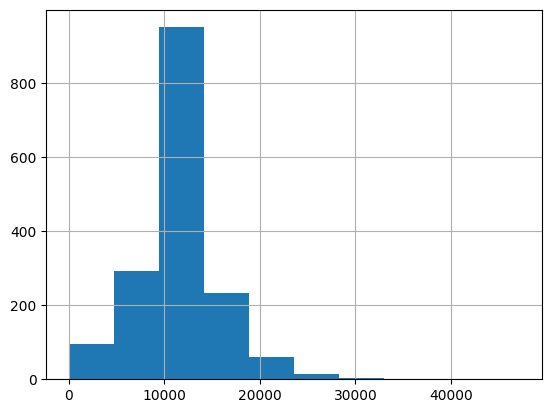

In [13]:
df["Prix mensuel (€)"].hist()

L'analyse du nombre de pièces des biens immobiliers dans l'échantillon révèle une moyenne de 3 pièces. Cependant, cette moyenne est influencée par une valeur aberrante, à savoir un appartement avec 418 pièces. Une inspection plus approfondie des données CSV montre que cet appartement possède une surface de seulement 127 m², ce qui est peu probable compte tenu du nombre élevé de pièces.

Il est raisonnable de conclure que cette observation est probablement une erreur de saisie ou de collecte de données. Il est peu probable qu'un appartement de seulement 127 m² puisse accueillir 418 pièces de manière réaliste. Par conséquent, il est recommandé de traiter cette observation comme une valeur aberrante et de la corriger ou de la supprimer de l'échantillon, afin de ne pas fausser les analyses ultérieures.

<Axes: >

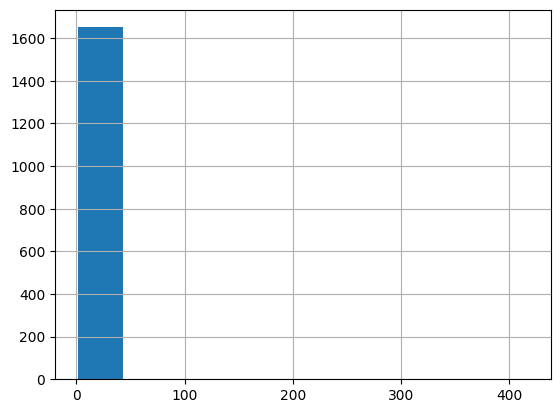

In [14]:
df["Pièce(s)"].hist()

La moyenne de la surface est estimée à environ 57.41 m², ce qui donne une indication de la taille moyenne des propriétés dans l'échantillon. Cependant, l'écart-type important de 47.80 m² suggère une grande variabilité dans les tailles des propriétés, ce qui signifie que les biens immobiliers peuvent avoir des surfaces très différentes les unes des autres.

Une observation notable est la surface minimale de 3 m², ce qui est inhabituellement petite pour un bien immobilier et soulève des doutes quant à la validité de cette valeur.

La distribution des surfaces est également révélée par les quartiles. Ainsi, 25% des biens immobiliers ont une surface inférieure à 28 m², tandis que 50% ont une surface inférieure à 45 m². De même, 75% des biens ont une surface inférieure à 68 m², ce qui montre comment la majorité des propriétés dans l'échantillon ont des surfaces relativement modestes.

Enfin, la surface maximale observée est de 649 m², indiquant la présence de biens immobiliers plus spacieux dans l'échantillon. Cette diversité de tailles des propriétés souligne l'importance de comprendre la répartition des surfaces pour toute analyse ou prise de décision liée au marché immobilier.

<Axes: >

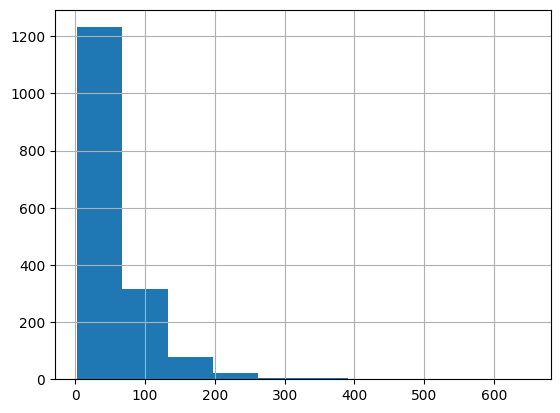

In [15]:
df["Surface (m2)"].hist()

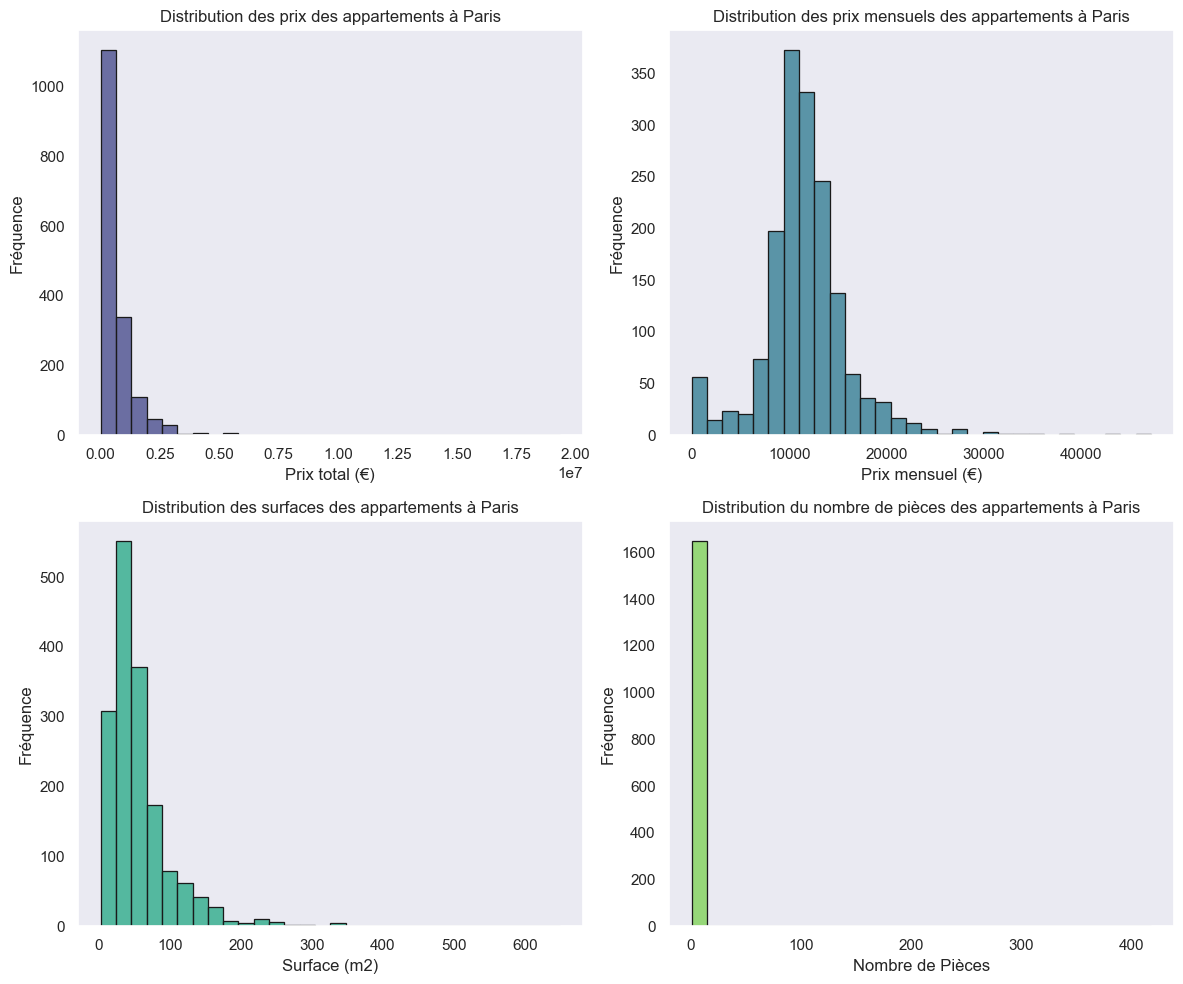

In [126]:
# Créer une figure avec quatre sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Histogramme pour 'Prix total (€)'
sns.histplot(df["Prix (€)"], bins=30, kde=False, color=sns.color_palette("viridis", 4)[0], ax=axes[0, 0], edgecolor='k')
axes[0, 0].set_title('Distribution des prix des appartements à Paris')
axes[0, 0].set_xlabel('Prix total (€)')
axes[0, 0].set_ylabel('Fréquence')

# Histogramme pour 'Prix mensuel (€)'
sns.histplot(df["Prix mensuel (€)"], bins=30, kde=False, color=sns.color_palette("viridis", 4)[1], ax=axes[0, 1], edgecolor='k')
axes[0, 1].set_title('Distribution des prix mensuels des appartements à Paris')
axes[0, 1].set_xlabel('Prix mensuel (€)')
axes[0, 1].set_ylabel('Fréquence')

# Histogramme pour 'Surface (m2)'
sns.histplot(df["Surface (m2)"], bins=30, kde=False, color=sns.color_palette("viridis", 4)[2], ax=axes[1, 0], edgecolor='k')
axes[1, 0].set_title('Distribution des surfaces des appartements à Paris')
axes[1, 0].set_xlabel('Surface (m2)')
axes[1, 0].set_ylabel('Fréquence')

# Histogramme pour 'Nombre de Pièces'
sns.histplot(df["Pièce(s)"], bins=30, kde=False, color=sns.color_palette("viridis", 4)[3], ax=axes[1, 1], edgecolor='k')
axes[1, 1].set_title('Distribution du nombre de pièces des appartements à Paris')
axes[1, 1].set_xlabel('Nombre de Pièces')
axes[1, 1].set_ylabel('Fréquence')

# Ajuster l'espacement entre les sous-graphiques
plt.tight_layout()
plt.show()

/var/folders/jl/05xr553n44v3_nqnn57t0f380000gn/T/ipykernel_16712/665074767.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Arrondissement', data=df, order=sorted(df['Arrondissement'].unique()), palette='viridis')


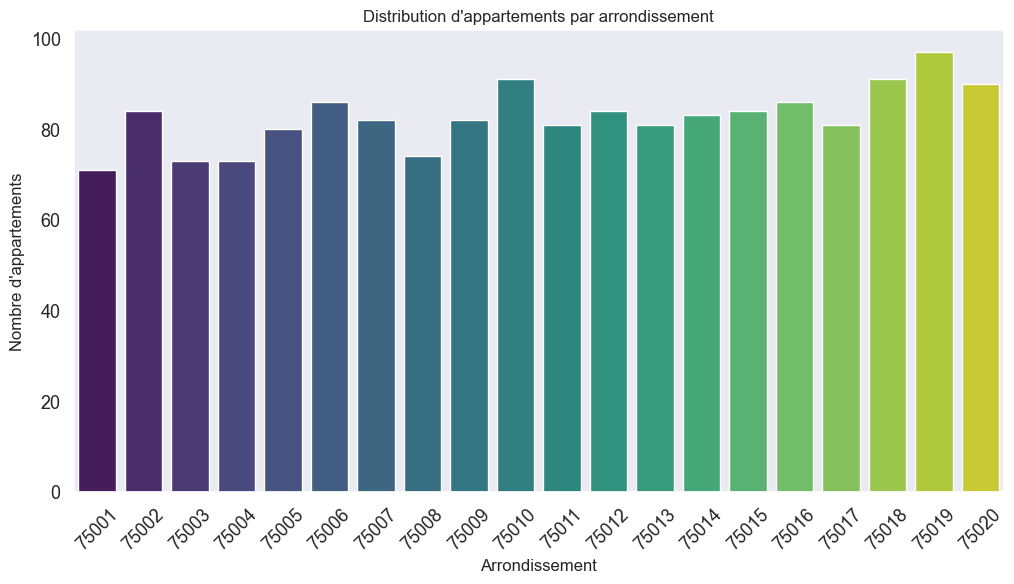

In [125]:
# Créer un bar plot avec seaborn
plt.figure(figsize=(12, 6))
sns.countplot(x='Arrondissement', data=df, order=sorted(df['Arrondissement'].unique()), palette='viridis')
plt.title("Distribution d'appartements par arrondissement")
plt.xlabel("Arrondissement")
plt.ylabel("Nombre d'appartements")
plt.xticks(rotation=45, fontsize=13)
plt.yticks(fontsize=13)
plt.show()

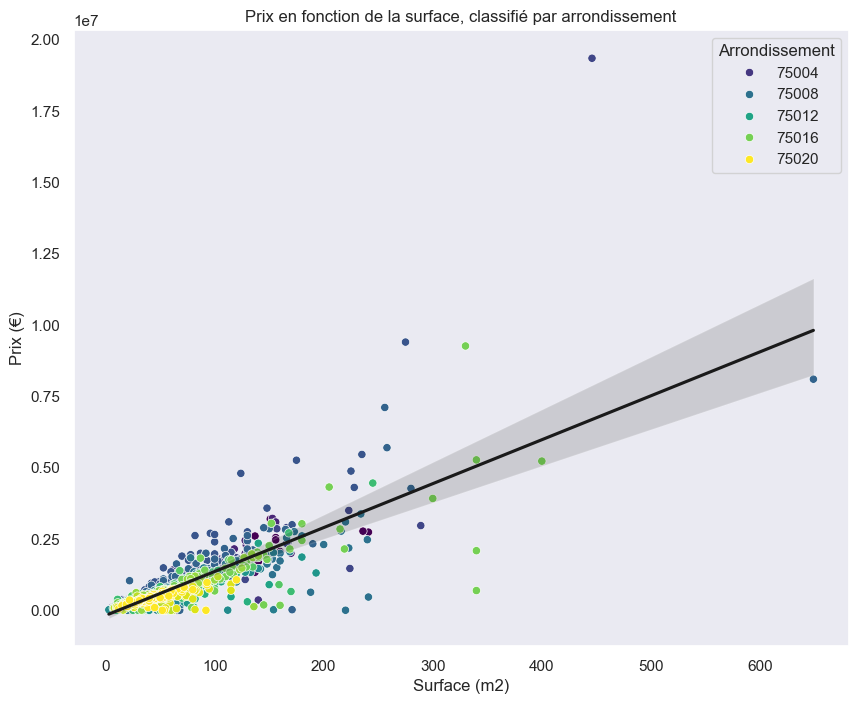

In [120]:
# Créer un scatter plot avec des couleurs différentes par arrondissement
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Surface (m2)', y='Prix (€)', hue='Arrondissement', data=df, palette='viridis')
sns.regplot(x='Surface (m2)', y='Prix (€)', data=df, scatter=False, color='.1')  # Ajouter une seule ligne de régression
plt.title('Prix en fonction de la surface, classifié par arrondissement')
plt.xlabel('Surface (m2)')
plt.ylabel('Prix (€)')
plt.show()

/var/folders/jl/05xr553n44v3_nqnn57t0f380000gn/T/ipykernel_16712/2504989730.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Arrondissement', y='Prix moyen (€)', data=prix_moyen_par_arrondissement, palette='viridis')


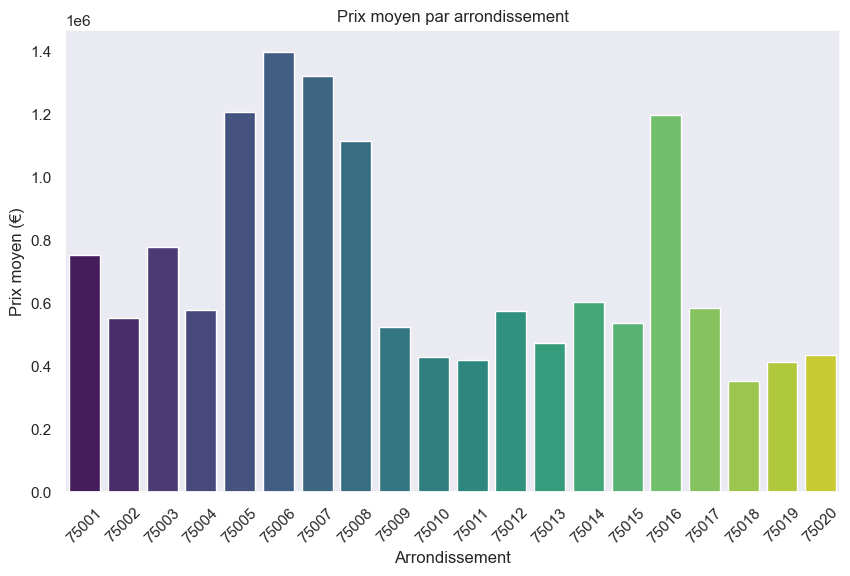

In [113]:
# Calculer le prix moyen par arrondissement
prix_moyen_par_arrondissement = df.groupby('Arrondissement')['Prix (€)'].mean().reset_index()
prix_moyen_par_arrondissement.columns = ['Arrondissement', 'Prix moyen (€)']

# Créer un bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Arrondissement', y='Prix moyen (€)', data=prix_moyen_par_arrondissement, palette='viridis')
plt.title('Prix moyen par arrondissement')
plt.xlabel('Arrondissement')
plt.ylabel('Prix moyen (€)')
plt.xticks(rotation=45)
plt.show()

In [16]:
# Standardize the data
scaler = StandardScaler()
scaler.fit(numerical_df)
data_scaled = scaler.transform(numerical_df)
dataStd = pd.DataFrame(data_scaled, columns=numerical_df.columns)

# On a besoin de voir les corrélations entre les variables 
# c'est pourquoi on standardise les valeurs, ainsi les valeurs seront
# tous sur la même échelle

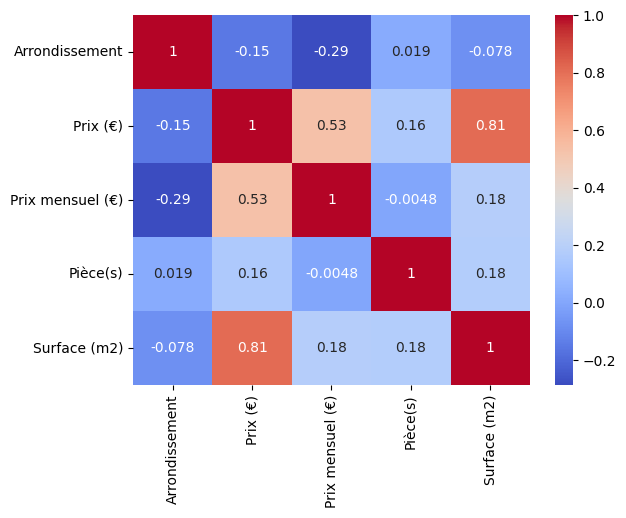

In [17]:
sns.heatmap(dataStd.corr(), annot=True, cmap='coolwarm');

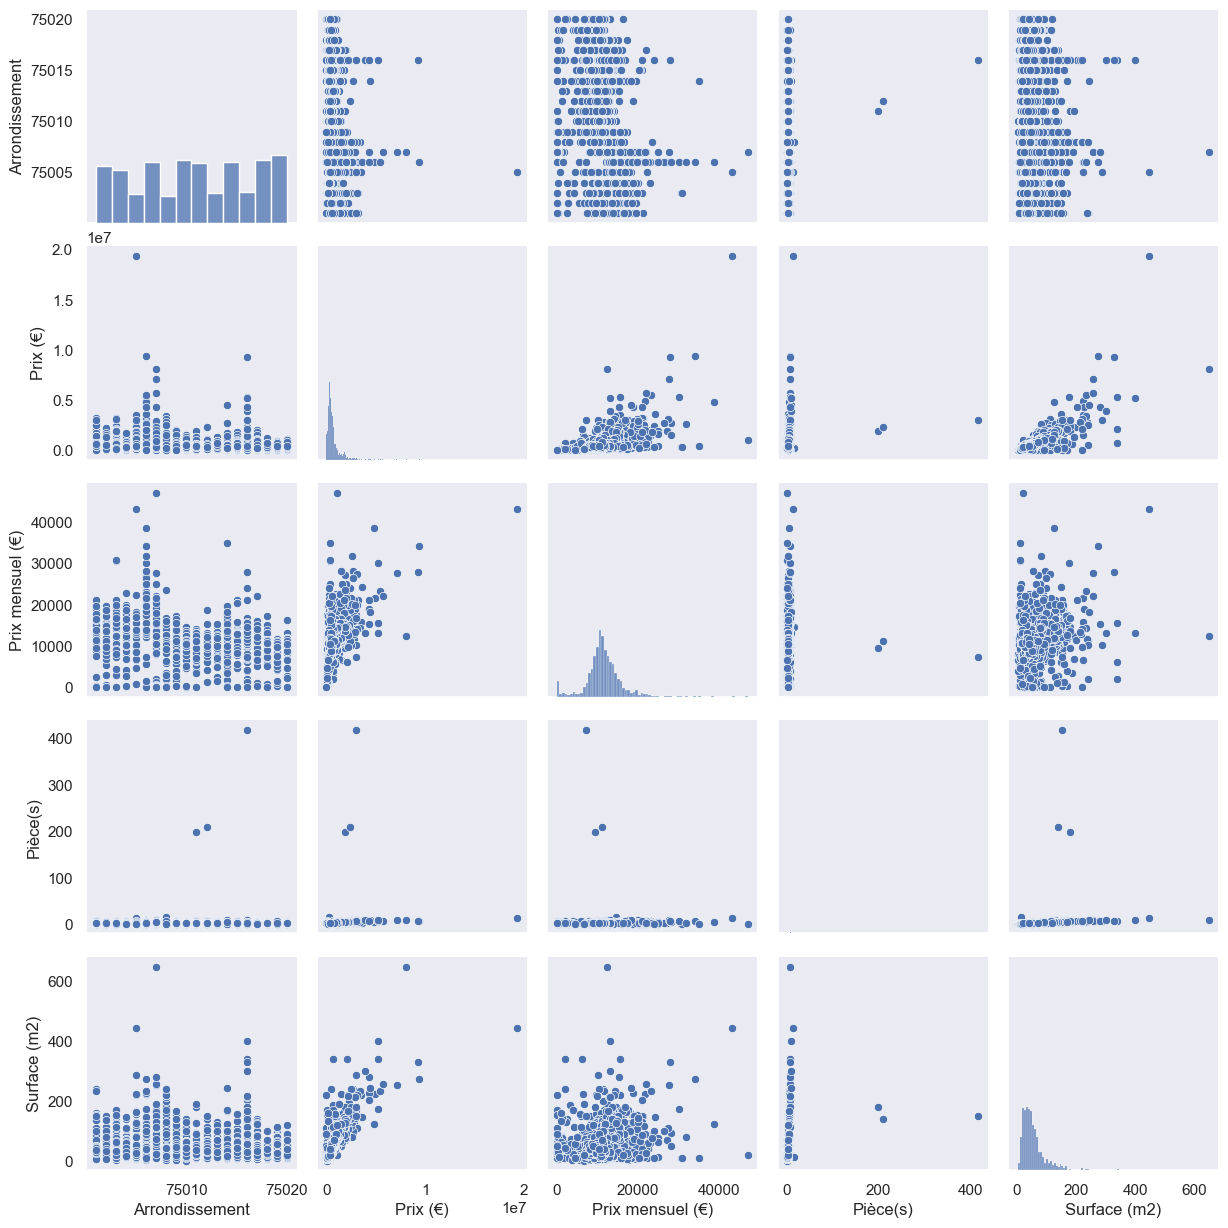

In [109]:
sns.pairplot(df)

On note que le nombre de pièces a une distribution concentrée avec des valeurs extrêmes, tandis que les prix et les surfaces présentent une large dispersion avec de nombreux points éloignés de la concentration principale, indiquant des valeurs extrêmes ou aberrantes. Le graphique inférieur droit identifie spécifiquement les valeurs aberrantes, isolant visiblement les données qui s'écartent de la tendance générale.

De plus on remarque une correlation entre la surface et prix car les points montrent globalement une tendance linéaire où y = x

On peut constater que la variable Prix est expliquée par les variables surface et prix mensuel, il sera donc important de les garder pour le modèle de regression qu'on va réaliser dans la suite du rapport, A noter aussi que le prix mensuel et la surface n'a une corrélation que de 0.18 donc nous supposons qu'il n'y aura pas de problème de multicolinéarité, qui augmente la variance des coefficients et qui nuit à l'interprétation des résultats

### Outlier detection

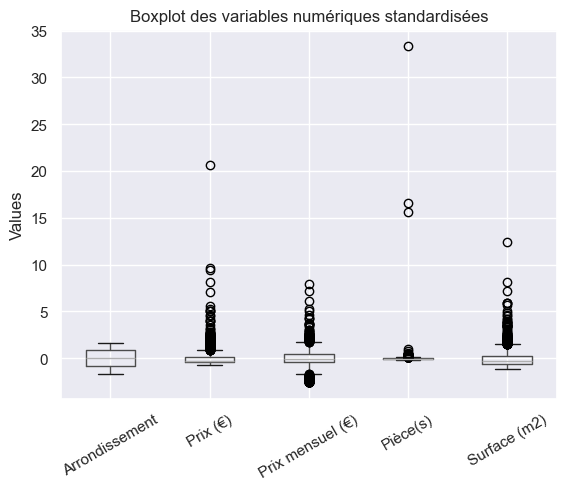

In [66]:
plt.figure()

dataStd.boxplot(rot=30)
plt.title("Boxplot des variables numériques standardisées")
plt.ylabel("Values")
plt.show()

Les variables "Arrondissement" et "Pièces" ont des plages de valeurs relativement étroites et moins de valeurs aberrantes, ce qui suggère une distribution plus serrée des données. En revanche, "Prix (€)", "Prix mensuel (€)" et "Surface (m²)" montrent une plus grande variabilité avec de nombreuses valeurs aberrantes, indiquant des écarts importants dans les données. La médiane semble relativement basse pour les catégories "Prix" et "Surface", ce qui pourrait indiquer une asymétrie dans la distribution des prix et des tailles des surfaces.

In [21]:
# Initialize the Isolation Forest model
isolation_forest = IsolationForest(contamination=0.05, random_state=42)

isolation_forest.fit(dataStd)
outlier_predictions = isolation_forest.predict(dataStd)

outliers_count = (outlier_predictions == -1).sum()

print(f"Total outliers identified: {outliers_count}")

Total outliers identified: 83


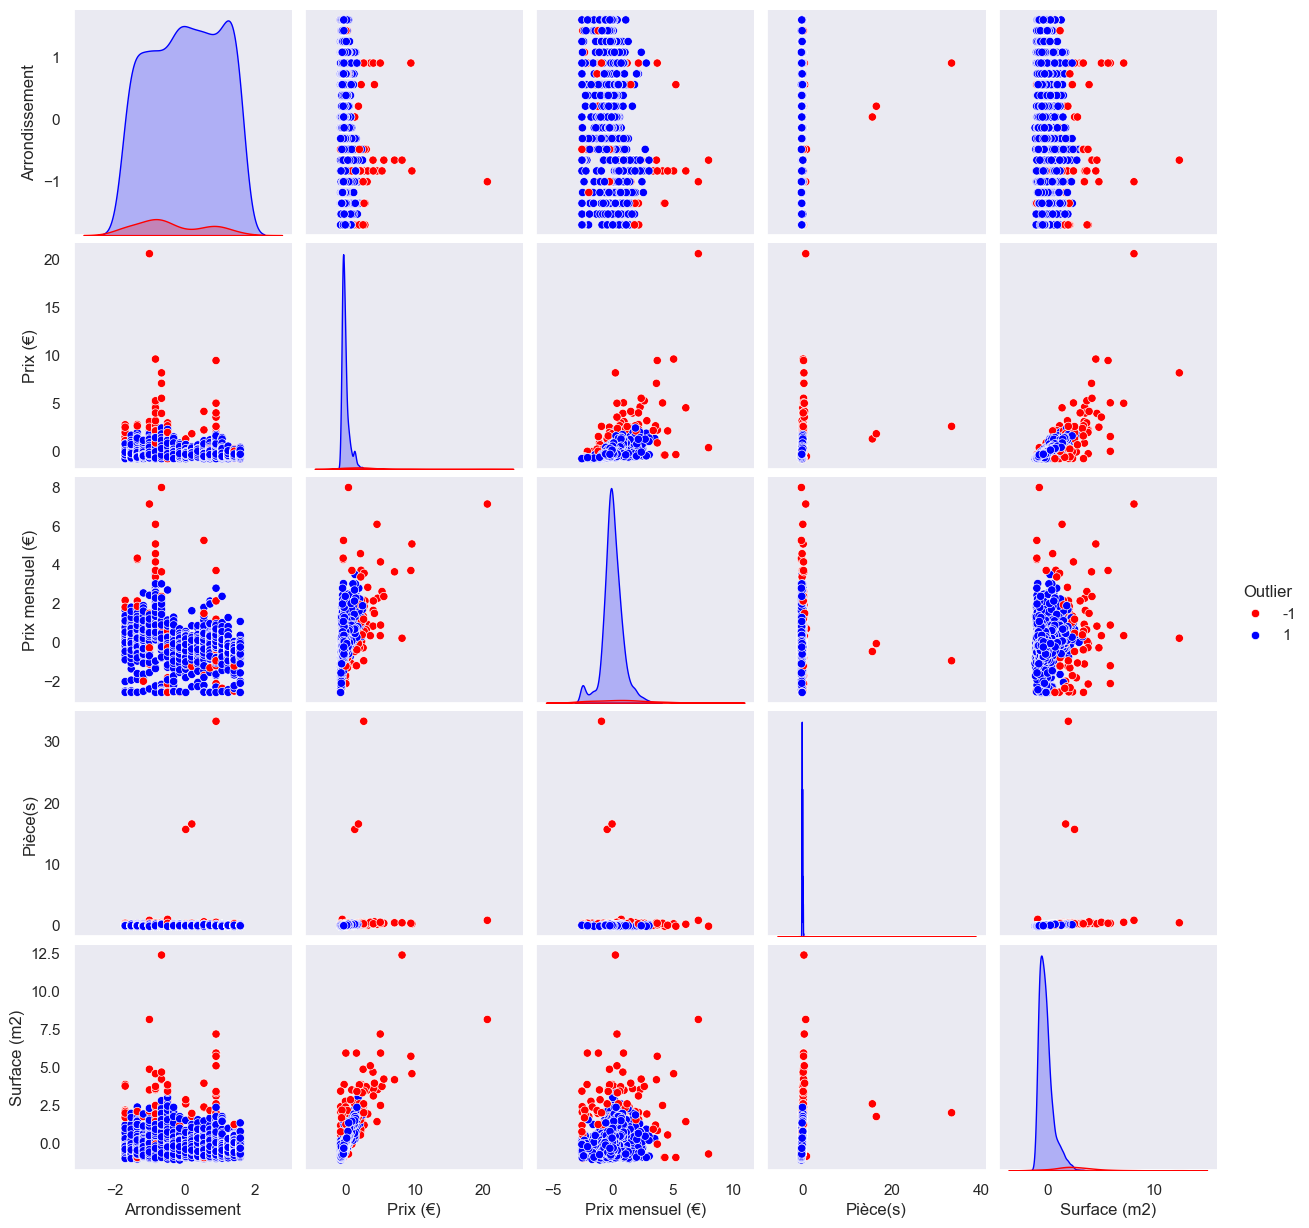

In [61]:
# Add a new column 'Outlier' to the DataFrame indicating whether each row is an outlier or not
dataStdCopy = dataStd.copy()
dataStdCopy['Outlier'] = outlier_predictions

# Create pair plots using seaborn
sns.pairplot(dataStdCopy, hue='Outlier', palette={-1: 'red', 1: 'blue'})
plt.show()

 Les points bleus représentent les données standard, tandis que les points rouges signalent des valeurs aberrantes. Il y a des distributions asymétriques pour le prix et la surface, comme en témoignent les longues queues sur les histogrammes de densité correspondants. Les valeurs aberrantes sont particulièrement notables dans la relation entre le nombre de pièces et les autres variables, ce qui suggère des anomalies spécifiques, comme des appartements exceptionnellement grands ou chers par rapport au reste de l'échantillon.

 Maintenant que nous avons détecté les outliers, on va les garder de côté puis en tirer une analyser après la regression pour savoir s'il faut les garder ou non.

### Réduction de dimension

In [68]:
pca = PCA()
pca.fit(dataStd)
pca_data = pca.transform(dataStd)
n = dataStd.shape[0] # nb of individuals
p = dataStd.shape[1] # nb of variables
print(n, "samples")
print(p, "variables")

1654 samples
5 variables


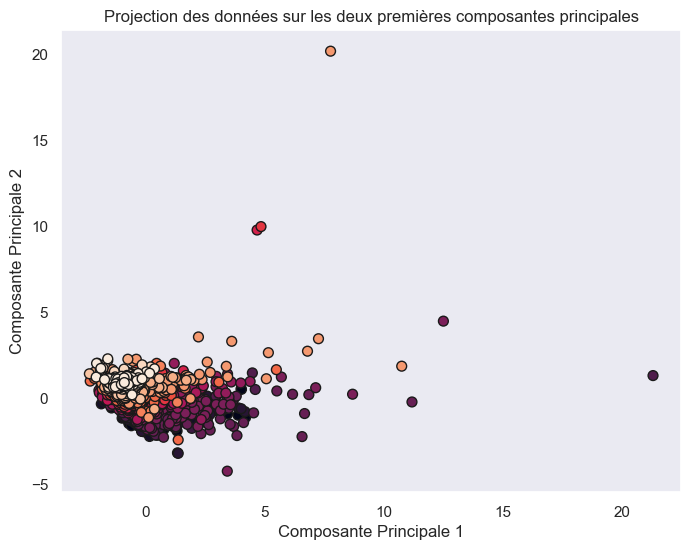

In [85]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], edgecolor='k', s=50, c=dataStd['Arrondissement'])
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.title('Projection des données sur les deux premières composantes principales')
plt.show()


Avec les 2 premières composantes, il n'y a pas assez de variance pour distinguer les appartements en fonction de son arrondissement

In [24]:
explained_variances = pca.explained_variance_
simple_var_proportions = explained_variances / explained_variances.sum()
cumulative_var_proportions = np.cumsum(simple_var_proportions)
labels = [f'PC{i}' for i in range(1, len(explained_variances) + 1)]

summary_table = pd.DataFrame({
    'Explained Variance': explained_variances,
    'Simple Variance Proportion': simple_var_proportions,
    'Cumulative Variance Proportion': cumulative_var_proportions
}, index=labels)

summary_table

,Explained Variance,Simple Variance Proportion,Cumulative Variance Proportion
PC1,2.163668,0.432472,0.432472
PC2,1.157170,0.231294,0.663766
PC3,0.893674,0.178627,0.842393
PC4,0.684562,0.136830,0.979222
PC5,0.103951,0.020778,1.000000


PCA semble être efficace puisque les trois premières composantes expliquent déjà 84% de la variance totale, et les quatre premières en expliquent 98%. Cela signifie que les données peuvent être réduit à 3 ou 4 dimensions tout en conservant la majorité de l'information.

<BarContainer object of 5 artists>

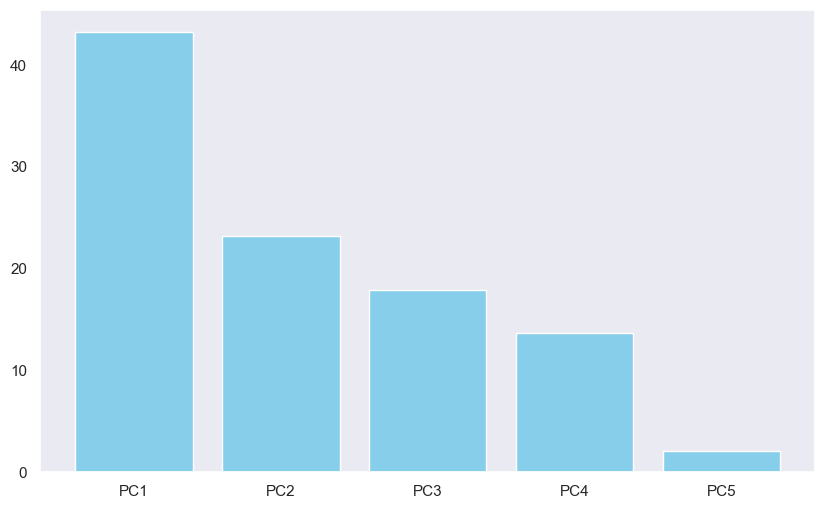

In [25]:
# Convert simple variance proportions to percentages
simple_var_proportions_percent = simple_var_proportions * 100

plt.figure(figsize=(10, 6))
plt.bar(summary_table.index, simple_var_proportions_percent, color='skyblue')

In [26]:
singular_values = np.sqrt(pca.explained_variance_)
corvar_data = {'id': dataStd.columns}
for k in range(p):
    corvar_data[labels[k]] = pca.components_[k,:] * singular_values[k]

coordvar = pd.DataFrame(corvar_data)
coordvar

,id,PC1,PC2,PC3,PC4,PC5
0,Arrondissement,-0.334234,0.670086,-0.492714,0.443867,-0.009609
1,Prix (€),0.948148,0.108672,-0.184512,0.005600,0.236081
2,Prix mensuel (€),0.643077,-0.478607,0.026800,0.588611,-0.103977
3,Pièce(s),0.247637,0.591439,0.749320,0.167270,-0.004721
4,Surface (m2),0.823467,0.342755,-0.233805,-0.336260,-0.193108


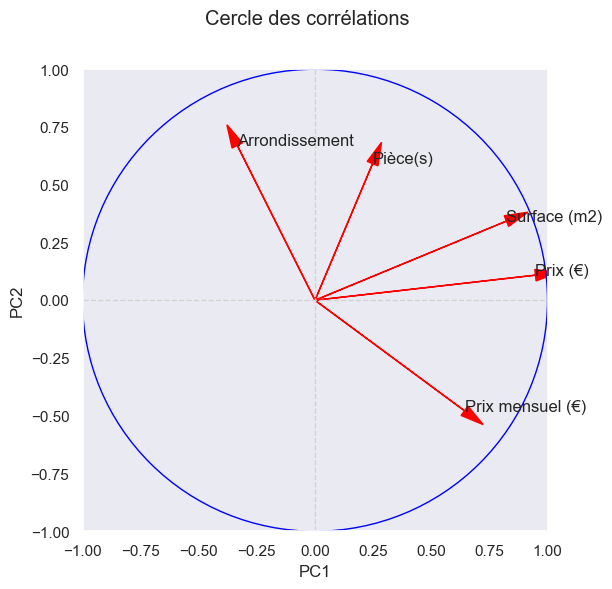

In [27]:
fig, axes = plt.subplots(figsize=(6, 6))
fig.suptitle("Cercle des corrélations")
axes.set_xlim(-1, 1)
axes.set_ylim(-1, 1)

# Ajout des titres
axes.set_xlabel('PC1')
axes.set_ylabel('PC2')

# Ajout des axes
axes.axvline(x=0, color='lightgray', linestyle='--', linewidth=1)
axes.axhline(y=0, color='lightgray', linestyle='--', linewidth=1)

# Ajout des noms des variables et des flèches
for j in range(p):
    axes.arrow(0, 0, coordvar[labels[0]][j], coordvar[labels[1]][j], head_width=0.05, head_length=0.1, fc='red', ec='red')
    axes.text(coordvar[labels[0]][j], coordvar[labels[1]][j], coordvar["id"][j])

# Ajout du cercle
circle = plt.Circle((0, 0), 1, color='blue', fill=False)
axes.add_artist(circle)

plt.show()

Le prix d'achat et la surface habitable sont étroitement liés à PC1, indiquant que généralement, une plus grande surface implique un prix plus élevé pour les biens immobiliers. Le loyer mensuel est aussi lié au PC1, mais dans une moindre mesure, suggérant que d’autres éléments influencent également le loyer au-delà de la surface de la propriété. D'autre part, l'arrondissement montre une corrélation plus marquée avec la deuxième composante principale (PC2), ce qui suggère qu'il affecte les valeurs immobilières d'une manière qui ne se résume pas uniquement à une augmentation de la surface ou du prix. Le nombre de pièces a une influence sur les deux composantes, bien que moins prépondérante que la surface ou le prix. Toutes ces variables sont relativement proches du cercle de corrélation, ce qui indique qu'elles sont assez bien représentées par ces deux composantes principales, bien qu'une certaine quantité d'informations soit perdue, comme le montre le fait qu'aucune variable n'est parfaitement alignée sur le cercle.

(1654, 5)

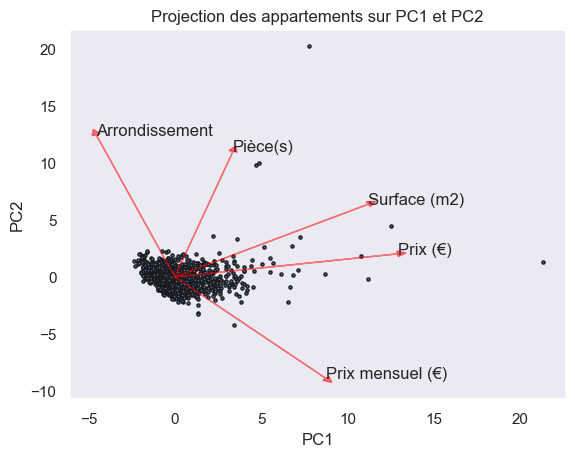

In [92]:
plt.scatter(pca_data[:,0], pca_data[:,1], edgecolor='k', s=5)
plt.title("Projection des appartements sur PC1 et PC2")
plt.xlabel("PC1")
plt.ylabel("PC2")
for i in range(pca.components_.shape[1]):
    plt.arrow(0, 0, pca.components_[0,i] * 20, pca.components_[1,i] * 20, alpha=0.5, color='red', head_width=0.5, head_length=0.5)
    plt.text(pca.components_[0,i] * 20, pca.components_[1,i] * 20, dataStd.columns[i])

pca_data.shape

À garder de côté pour faire une regression linéaire sur les individues projetés, pour simplifier tout en conservant le maximum d'information.

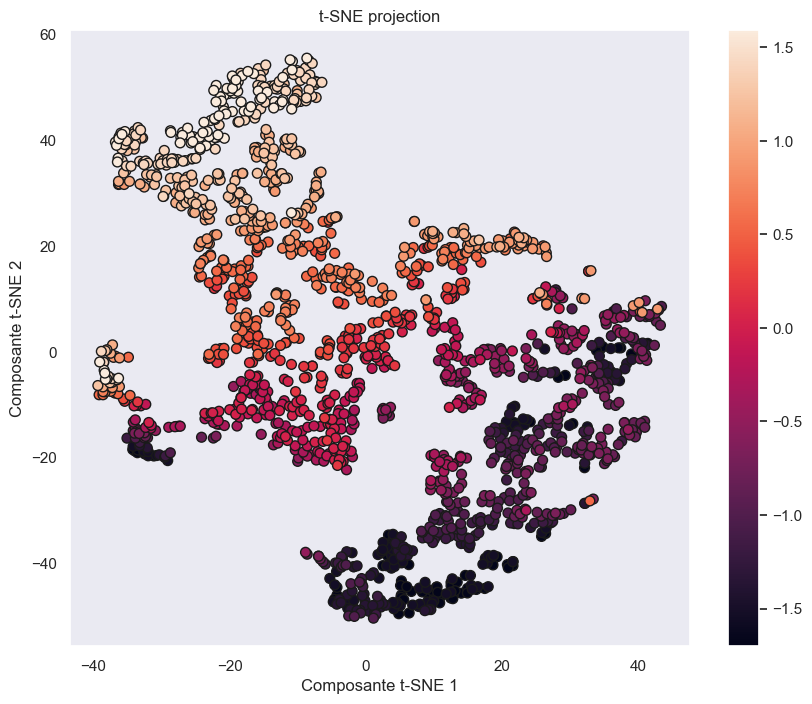

In [106]:
# Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(dataStd)

# Visualisation des données réduites avec t-SNE
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=dataStd['Arrondissement'], edgecolors="k", s=50)
plt.title('t-SNE projection')
plt.xlabel('Composante t-SNE 1')
plt.ylabel('Composante t-SNE 2')
plt.colorbar()
plt.show()


t-SNE à l'air de mieux capturer la variance des données en 2 composantes principales quand on le compare à PCA, MDS et Isomap

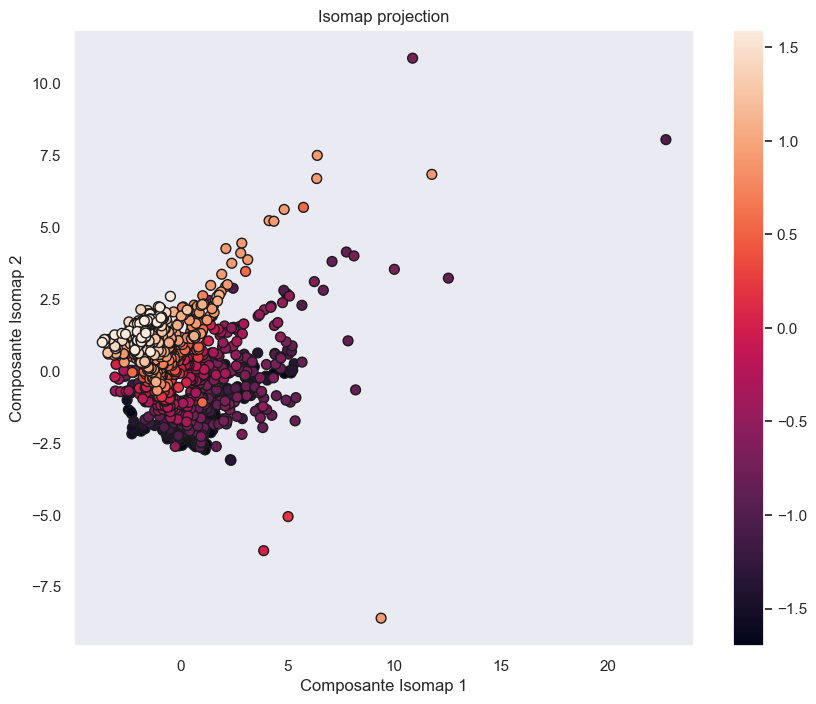

In [104]:
# Réduction de dimension avec Isomap
isomap = Isomap(n_components=2)
X_isomap = isomap.fit_transform(dataStd)

# Visualisation des données réduites avec Isomap
plt.figure(figsize=(10, 8))
plt.scatter(X_isomap[:, 0], X_isomap[:, 1], c=dataStd['Arrondissement'], edgecolors="k", s=50)
plt.colorbar()
plt.title('Isomap projection')
plt.xlabel('Composante Isomap 1')
plt.ylabel('Composante Isomap 2')
plt.show()


L'isomap ne capture pas correctement la variance de chaque données.
Changer le nombre de composantes principales de modifie pas beaucoup le scatterplot

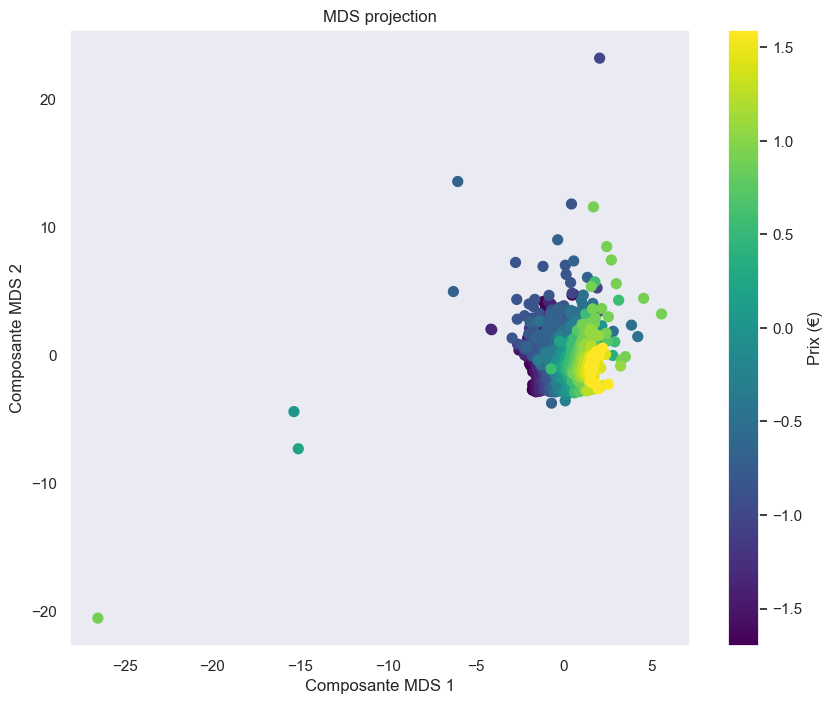

In [105]:
# Réduction de dimension avec t-SNE
# Appliquer MDS
mds = MDS(n_components=2, random_state=42)
X_mds = mds.fit_transform(dataStd)

# Visualiser les données réduites avec MDS
plt.figure(figsize=(10, 8))
plt.scatter(X_mds[:, 0], X_mds[:, 1], c=dataStd['Arrondissement'], cmap='viridis', s=50)
plt.colorbar(label='Prix (€)')
plt.title('MDS projection')
plt.xlabel('Composante MDS 1')
plt.ylabel('Composante MDS 2')
plt.show()

Le MDS ne capture pas correctement la variance des données en 2 composantes principales.
Sachant que j'ai pris 2 minutes à lancer l'algo pour 2 PC, je vais éviter de le faire avec 3 PC qui aurait besoin de beaucoup plus de temps